# Making 3-Color Images


In this notebook I'll describe how I created 3-color images for all the public
chandra observations in the archive.

I'll talk about some the processing step

**These image are HIGHLY processed.**  

While they steps discussed below were designed to be linear and flux preserving; they 
do involve adaptive smoothing and scaling which can **definitely** introduce small scale spatial
artifacts.



In [1]:
import os
import sys

import IPython.core.display as display
import glob

assert "ASCDS_INSTALL" in os.environ, "Please setup for CIAO before starting this notebook"
os.sys.path.insert(0,os.environ["ASCDS_INSTALL"]+"/lib/python2.7/site-packages")
os.sys.path.insert(1,os.environ["ASCDS_INSTALL"]+"/contrib/lib/python2.7/site-packages")

from pychips import *
from pychips.hlui import *
from pycrates import read_file
from paramio import pget


from ciao_contrib.runtool import make_tool
from ciao_contrib.cda.data import download_chandra_obsids

# get from https://github.com/kglotfelty/LUT
from chips_contrib.lut.lutcolors import *



In [2]:
!ciaover -v

The current environment is configured for:
  CIAO        : CIAO 4.9 Friday, December  2, 2016
  Tools       : Package release 1  Friday, December 2, 2016
  Sherpa      : Package release 1  Friday, December 2, 2016
  Chips       : Package release 1  Friday, December 2, 2016
  Prism       : Package release 1  Friday, December 2, 2016
  Obsvis      : Package release 1  Friday, December 2, 2016
  Core        : Package release 1  Friday, December 2, 2016
  Graphics    : Package release 1  Friday, December 2, 2016
  Contrib     : Package release 4  Thursday, July 20, 2017
  bindir      : /export/ciao-4.9/bin
  Python path : /export/ciao-4.9/ots/bin
  CALDB       : 4.7.6

CIAO Installation: Linux64
System information:
Linux lenin 2.6.32-696.6.3.el6.x86_64 #1 SMP Wed Jul 12 14:17:22 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux


## Processing parameters

This processing is done with minimal parameters 

In [3]:
obi="13736"

binsize=4
minflux=1e-5
logmin=-10
logmax=-4

## Download data

Retrieve files from the archive. 

Generally we advocte **always** reprocess your data with `chandra_repro`; but since I'm just making pretty pictures 
I won't here.  

Note:  There are still some early observations in the archive (data taken before 2000-01-24) that were not
included in Repro-4.  Those data **do** need to be repro.

I only need certain files so that's all I download.

In [4]:
download_chandra_obsids([obi], "bpix,fov,asol,evt2,msk".split(","))

[True]

In [5]:
# This is what I did when I needed to run chandra_repro
#
#download_chandra_obsids([obi], "bpix,fov,asol,evt1,flt,msk,mtl,stat,bias,pbk,dtf".split(","))
#chandra_repro = make_tool("chandra_repro")
#chandra_repro(obi,obi+"/repro", clobber=True)

## Make fluxed images

The first step is to create exposure corrected images.

Enter `fluximage` 

In [6]:
fluximage = make_tool("fluximage")
fluximage.punlearn()

Now let's setup the pameters:

In [7]:
fluximage.infile=obi+"/primary/"
fluximage.outroot=obi+"/"
fluximage.bands="broad,soft,medium,hard"
# TODO: replace soft with soft+ultrasoft

> I think we should replace the `soft` band with `soft+ultrasoft` (ie go from 0.3:1.2).  There are a lot of
> super-soft sources that are not being visualized in some important fields; and the increased in background
> is minimal.

Now, the important parameter: `binsize`.  

`fluximage` makes images and exposure maps only as big as needed (as definied by the limits 
of the field-of-view files).

Making exposure maps is very time consuming.  It's essentially a 3D convolution followed by a projection but given
the various coordinate systems involved it cannot be done with FFTs.  

The only way to really speed it up is to use a coarsely binned aspect histogram.  Fluximage does this by using a fraction (half?) binsize rather than the default 0.5".   This yields **significant** improvements in speed.  It also, by default,
runs things in parallel to take advantage of multiple-cpus.

In [8]:
fluximage.binsize=binsize

All set, let's run it.

In [9]:
fluximage(clobber=True)

Running fluximage
Version: 12 September 2016

Found 13736/primary/acisf13736N001_evt2.fits.gz
Using event file 13736/primary/acisf13736N001_evt2.fits.gz
Using CSC ACIS broad science energy band.
Using CSC ACIS soft science energy band.
Using CSC ACIS medium science energy band.
Using CSC ACIS hard science energy band.
Aspect solution 13736/primary/pcadf444947551N001_asol1.fits found.
Bad-pixel file 13736/primary/acisf13736_000N001_bpix1.fits.gz found.
Mask file 13736/secondary/acisf13736_000N001_msk1.fits found.

The output images will have 606 by 786 pixels, pixel size of 1.968 arcsec,
    and cover x=3572.5:5996.5:4,y=2844.5:5988.5:4.

Running tasks in parallel with 4 processors.
Creating aspect histograms for obsid 13736
Creating 20 instrument maps for obsid 13736
Creating 20 exposure maps for obsid 13736
Combining 5 exposure maps for 4 bands (obsid 13736)
Thresholding data for obsid 13736
Exposure-correcting 4 images for obsid 13736

The following files were created:

 The clipped 

Let's go ahead and display the broad-band image.

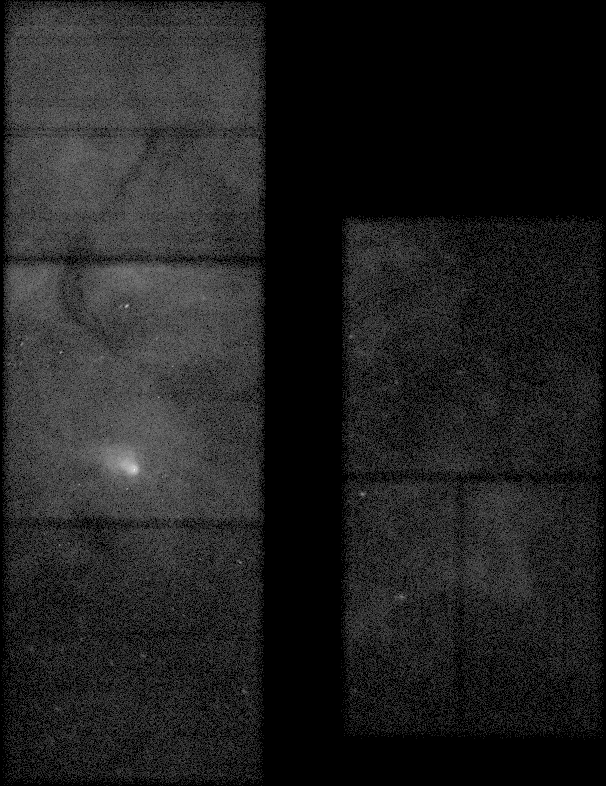

In [10]:
!ds9 $obi/broad_thresh.img -scale log -view colorbar no -export png ds9_01.png -quit

img = display.Image(filename="ds9_01.png")
display.display_png(img)

> Note: I used `export` above since it saves the entire image, not just what is being displayed.

## Adaptive smooth 

### `dmimgadapt` vs `csmooth` ?


### Broad band

In [11]:
dmimgadapt = make_tool("dmimgadapt")
dmimgadapt.punlearn()

The input file name used with `dmimgadapt` needs a bit of explanation, especially for those unfamiliar with 
the DM tools.  Here's the code and the details follow:

In [12]:
fov = glob.glob(obi+"/primary/*fov*")
infile_w_fov="{dir}/{band}_flux.img[sky=region({fov})][opt full]"
broad=infile_w_fov.format(dir=obi,band="broad",fov=fov[0])
print(broad)

13736/broad_flux.img[sky=region(13736/primary/acisf13736_000N001_fov1.fits.gz)][opt full]


```
broad_flux.img
```

> Yes, I am going against all my instincts and smoothed the exposure corrected, flux image, `_flux.img`.  **Sigh** 
>
> I am a strong believer that you should smooth your counts image, and smooth the exposure map
> separately and then divide to get the smoothed flux image. 

$
    g*\frac{C}{E} \neq \frac{g*C}{g*E}
$


> Why?  If I have 0 counts in a pixel (common)
> then when I smooth the raw counts/expmap image, the exposure value _under_ that 0 counts is not 
> included.
>
> Despite my convictions, I'm going ahead and doing this here.  Why?
>
> What I want to do is smooth all images, from all observations the same way.  The only way to do that is to
> exposure correct the images before smoothing.  That is, smoothing a 1 ksec observation so that there is at least
> 1 count per pixel is very different than smoothing a 100ksec observation so that there is at least 1 count per pixel.
> The short observation would be heavily smoothed whereas the long observation would only be lightly smoothed.  
> The same object observed in both would look very different.
>
> TBD: I could use the smoothing scales determined from the fluxed image and apply it separately to the
> exposure map and raw counts


```
[sky=region(FOV)]
```

> Be defintion, all the events should be inside the FOV file so what this is really doing is
> setting the edge of the detector in the file's _subspace_ .  The `dmimgadapt` tool
> uses the subspace information to know which pixels to smooth and to adjust the smoothing functions at the
> edge of the image.


```
[opt full]
```

> This simply preserves the size of the images.  Otherwise the images would try to shrink to the 
> size of the FOV, which they already are, but may cause some edge pixels to be dropped.

In [13]:
dmimgadapt.infile=broad

Luckily setting the output file name is a lot easier

In [14]:
dmimgadapt.outfile=obi+"/broad_flux.asm"

These parameters control the smoothing function.

In English (or my bad version of English) it says:

    Use a Gaussian smoothing kernel with a variable sigma that goes from 0.5 pixels to 45 pixels 
    in 100 linearly spaced steps.


I am also a big fan of using the `cone` kernel -- especially when experimenting since it is much faster 
than the `gaus` and provides a similar look.  The other smoothing `function` values are worth looking at.

In [15]:
dmimgadapt.function="gaus"
dmimgadapt.minrad=0.5
dmimgadapt.maxrad=45
dmimgadapt.numrad=100
dmimgadapt.radscale="linear"

Now, the most important smoothing parameter is knowing when to stop. 

The `counts` parameter is this threshold.  It is the integrated value of the convolution kernel over the data at that
location.

For integer pixel values, a value of `9` would be `9` counts or a SNR $\approx \sqrt(9)=3$.

But here I am smoothing the exposure corrected, fluxed image in units of `photons/cm^2/sec`, so the `counts` value 
need to be expressed in those same units.

The default I chose for this parameter **definitely** is based on trial-and-error though we an get a ball-park
estimate.

Let's say a typical value for the effective area is `300cm^2`.

And lets say a typical observation is `20ksec`.

So with the default that means

$
1.0E-5 * 300.0 *2.0E4 = 60 
$

counts per binned pixel. (Default binsize=4.)

That seems something high (and maybe it is); but it seems to work well for a large number of datasets.

I am **definitely** going to loose faint point sources but chip gaps and other detector edges are not a problem.



In [16]:
dmimgadapt.counts = minflux

Now, the real reason for starting with the broad band is that I want to compute the smoothing scales for the broad
band and then use them to smooth the soft, medium, and  hard band images.

While it is true the sum of the soft+medium+hard flux images does not equal the broad band image.  It is true that the
soft+hard+medium **counts** images does equal the broad band counts.  So by using the broad band to set the 
radii we are in a way making sure that the same features are smoothed consistently

> _Anyone convinced by this?  Horrible argument, but I'm going with it._


You can adaptively smooth the soft, medium, and hard band independently.  However, the 3 color images that get produced
often have color halos around all the point sources.  Say a source is dominated by soft photons.  The red-channel 
at that location would not be smoothed very much whereas the green and blue channels would be smoothed a lot.  The 
effect would be a slight "yellow" halo around the source.

> Left for a user experiment at this point.



In [17]:
dmimgadapt.radfile=obi+"/broad.radii"

and now we can run the tool.

In [18]:
dmimgadapt(clobber=True)

Let's see the smoothed image

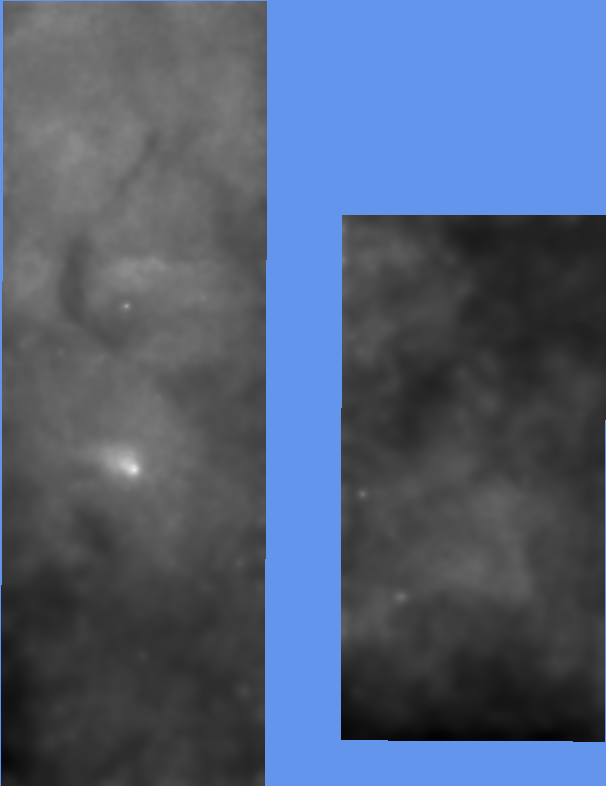

In [19]:
!ds9 $obi/broad_flux.asm -scale log -view colorbar no -nan cornflowerblue -export png ds9_02.png -quit

img = display.Image(filename="ds9_02.png")
display.display_png(img)

Note:  The pixel values outside the `FOV` have not been included in the smoothing and have been set to `NaN`.  Those
pixels are shown in a light blue color.


We can also take a look at the smoothing scales

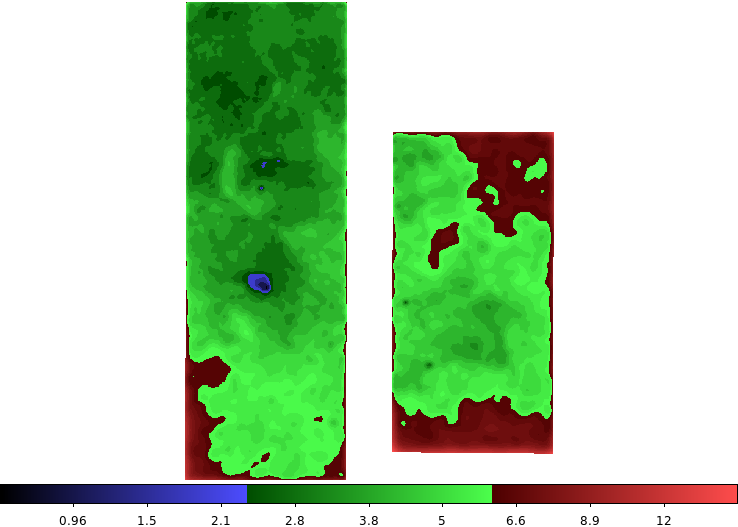

In [20]:
!ds9 $obi/broad.radii -zoom to fit -scale asinh -view colorbar yes -cmap standard -saveimage png ds9_03.png -quit

img = display.Image(filename="ds9_03.png")
display.display_png(img)

> Note: I had to switch to `-saveimage` and use `-zoom to fit` to be able to include the colorbar.

### Log scale


This step is definitely not necessary.

I'm doing it here for a couple of reasons.  I can take the $log_{10}$ of the images then I can express the 
min and max limits in log space rather than try to express them in flux space.  

I also can convert the images from float point values to scaled integers.  This **REALLY** isn't necessary, except 
I'm using my own disk space and there are lot of the files.  FPE's don't compress well, scaled integers do.

Since I'm just making pretty pictures, I'm OK loosing some precision. 



In [21]:
dmimgcalc = make_tool("dmimgcalc")
dmimgcalc.punlearn()

Now setup input and output files

In [22]:
dmimgcalc.infile=obi+"/broad_flux.asm"
dmimgcalc.outfile=obi+"/broad_flux.log"

I'm going to convert the images to scaled integers.  So I need to pick a resolution below which 
I don't mind loosing flux.  I could be more agressive here, but I'll go with

In [23]:
ires=16384.0
iscale=(logmax-logmin)/ires

where `logmin` and `logmax` are the limits I'm going to be use using when making JPEGs.


Okay, so the full expression for the calculation then is:

In [24]:
dmimgcalc.op="imgout=((long)(0.5+((log(img1)-{zero})/{scale})))".format(zero=logmin,scale=iscale)   

and then let's run it.

In [25]:
dmimgcalc(clobber=True)

Finally, I scaled the integers, but _FITS_ and the DM don't know that.  I have to add some
_FITS_ keywords into the header to identify the integer to FPE scaling and the zero point I used.  

In [26]:
dmhedit = make_tool("dmhedit")
dmhedit.punlearn()

In [27]:
dmhedit(dmimgcalc.outfile, file=None,op="add",key="BSCALE",value=iscale)
dmhedit(dmimgcalc.outfile, file=None,op="add",key="BZERO",value=logmin)

Okay, let's check the results:

In [28]:
!dmlist $dmimgcalc.outfile cols

 
--------------------------------------------------------------------------------
Columns for Image Block broad_flux.log
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   broad_flux.log[606,786]              Real4(606x786) -Inf:+Inf            
 
--------------------------------------------------------------------------------
Image Rescaling for Image Block broad_flux.log
--------------------------------------------------------------------------------
 
Scaled Data = -10 + 0.000366211 * Raw Data
 
--------------------------------------------------------------------------------
Physical Axis Transforms for Image Block broad_flux.log
--------------------------------------------------------------------------------
 
Group# Axis# 
   1   1,2    sky(x) = (+3572.50) +(+4.0)* ((#1)-(+0.50))
                 (y)   (+2844.50)  (+4.0)  ((#2) (+0.50))
 
-----------------------------------------

> Great.  It is now recognized as a `Real4` image with the `Scaled Data` expression I expected.

### Check limits: Make image histogram

I've added this here more as a diagnostic than an operational step.  The 
procedure creates images using a fixed upper and lower limit which I used for all
datasets.

This may not be a good idea; but I like the concept that the same color means the same thing everywhere.

But its really hard for this to work universally given our heterogeneous datasets.

The easiest thing it to just make a histogram of the pixel values and see where it falls without our limits


In [29]:
dmimghist=make_tool("dmimghist")
dmimghist.punlearn()

Setup input and output files

In [30]:
dmimghist.infile=obi+"/broad_flux.log"
dmimghist.outfile=obi+"/broad_flux.hist"

Setup the histogram limits.  Remember, I'm working in log space now.  I made the limits a bit wider than my
default values so I can see what spills over (if any).

Setting `strict=False`, will put any pixels below the lower limit into the min bin and above the upper limit into the
max bin.  Just so we don't miss anything.

In [31]:
dmimghist.hist="-12:-2:0.01"
dmimghist.strict=False

And now run it.  

In [32]:
dmimghist(clobber=True)

Now let's plot it.  

In [33]:
def my_print(fmt=".png"):
    "Display the current ChIPS window in IPython as a PNG"
    import tempfile as tempfile
    fname = tempfile.mkstemp(prefix='chips_temp', suffix=fmt, dir=os.environ["ASCDS_WORK_PATH"])[1]
    # Get ChIPS to create a PNG of the current window
    print_window(fname, 'clobber=true')
    assert os.path.exists(fname) == True
    img = display.Image(filename=fname)
    display.display_png(img)
    os.unlink(fname)

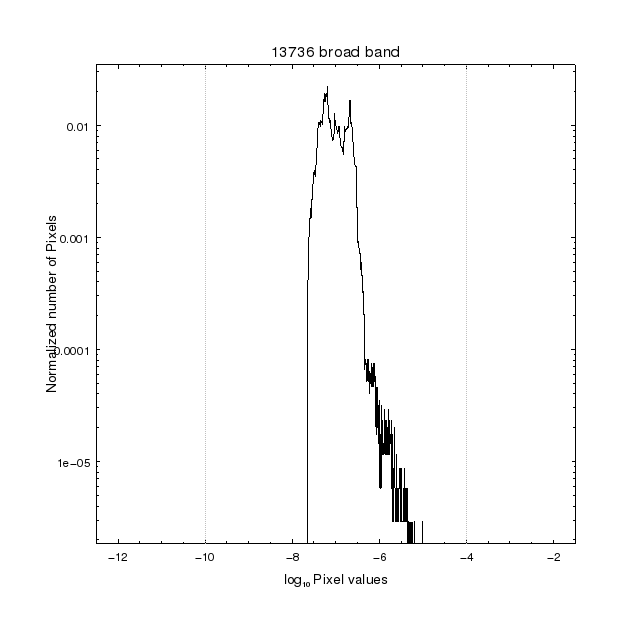

In [34]:
hist = read_file(dmimghist.outfile)

clear()
xl = hist.get_column("bin_low").values
xh = hist.get_column("bin_high").values
y = hist.get_column("normalized_counts").values
add_histogram(xl,xh,y)
log_scale(Y_AXIS)
add_vline(logmin)
add_vline(logmax)
set_line("all","style=dot color=gray")

set_plot_xlabel("log_{10} Pixel values")
set_plot_ylabel("Normalized number of Pixels")
set_plot_title(obi+" broad band")

my_print("chips_01.png")

In [35]:
clear()

> Okay, we see all the pixels are within the limits.  Maybe too compressed?

### Make JPEG

Now let's make the broad-band JPEG

I could use `chips` but remote-display/OpenGL/headless behavior is messy.  Using `dmimg2jpg`


In [36]:
dmimg2jpg = make_tool("dmimg2jpg")
dmimg2jpg.punlearn()

Setup input and output file names per usual

In [37]:
dmimg2jpg.infile=obi+"/broad_flux.log"
dmimg2jpg.outfile="broad.jpg"

Now we setup the min/max limits for the scaling.  These stretch/compress the color/contast.

In [38]:
dmimg2jpg.minred=logmin
dmimg2jpg.maxred=logmax

Since I've already $log_{10}$ scaled my images, `dmimg2jpg` should now use linear scaling

In [39]:
dmimg2jpg.scalefun="linear"

Well, not everything works in Python as it does from the command line.  In particular the `runtool` modules
from whence we import `make_tool` doesn't work-and-play well with redirected, ie `)someval`,  parameter values.  So I need to go ahead and set these to the actual values here.

In [40]:
lut = pget( "lut", "grey")
dmimg2jpg.lut= lut
dmimg2jpg.regioncolor="white"
dmimg2jpg.gridcolor="white"
dmimg2jpg.showaim=False
dmimg2jpg.showgrid=False

And now run the tool

In [41]:
dmimg2jpg(clobber=True)

and display the results

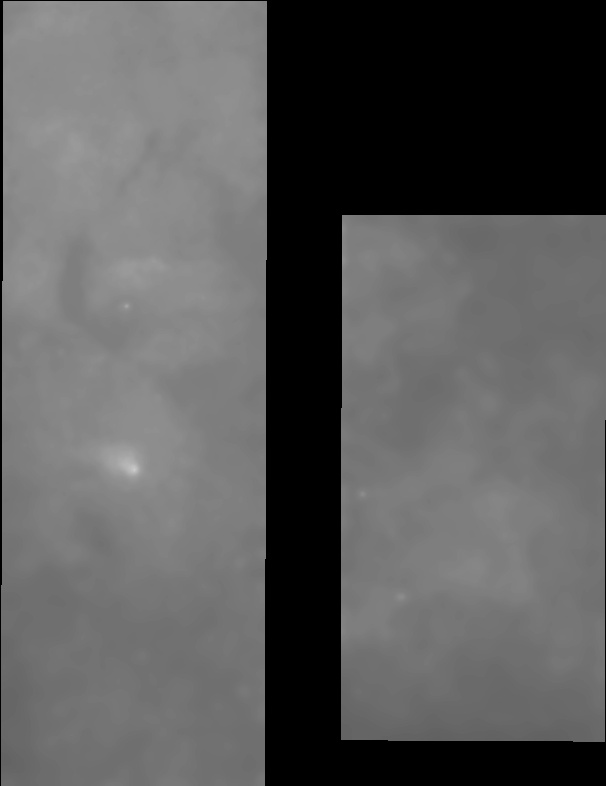

In [42]:
img = display.Image(filename=dmimg2jpg.outfile)
display.display_jpeg(img)

Not too surprising -- it looks  a lot like the image display from ds9 shown above.  The contrast is a bit less
with our choice of min/max scaling limits.   

But the point of this is to get nice 3-color images so let's move on.

### Repeat for each band


We now repeat the same adaptive smoothing, image scaling as before but now with the soft, medium, and hard energy band fluxed images.

The difference is that we now use the broad band radii to determine the smoothing scales.

In [43]:
radfile = dmimgadapt.radfile
dmimgadapt.inradfile = radfile
dmimgadapt.radfile=""

Now loop over the energy bands and smooth.  Note:  still using the same FOV filter as before.

In [44]:
for band in ["soft","medium","hard"]:
    dmimgadapt.infile=infile_w_fov.format(dir=obi,band=band,fov=fov[0])
    dmimgadapt.outfile=obi+"/{}_flux.asm".format(band)
    dmimgadapt(clobber=True)

This step is not necessary.

To visualize the per-band images I'm going to create custom color lookup table.  I'm going to create a
color map that goes from black to white through my favorite color.  The standard "red", "green", and "blue" are 
perfectly fine and in some sense optimal - but they can be hard to see.  So I'm going with slightly different colors:


In [45]:
def make_lut(color,outfile):
    red=lut_colors(["black",color,"white"])
    r2=["{} {} {}\n".format(*r) for r in zip(*red)]
    with open(outfile,"wb") as fp:  fp.writelines(r2)

make_lut("firebrick","my_red.lut")
make_lut("forestgreen","my_grn.lut")
make_lut("dodgerblue","my_blu.lut")

Ok, now let's display these 

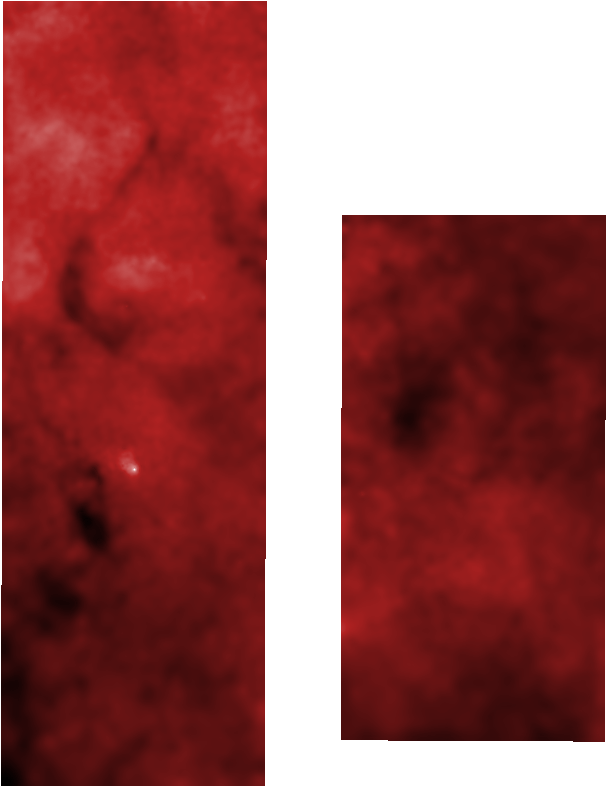

In [46]:
!ds9 $obi/soft_flux.asm -scale log -view colorbar no -cmap load my_red.lut -export png ds9_03_red.png -quit

img = display.Image(filename="ds9_03_red.png")
display.display_png(img)

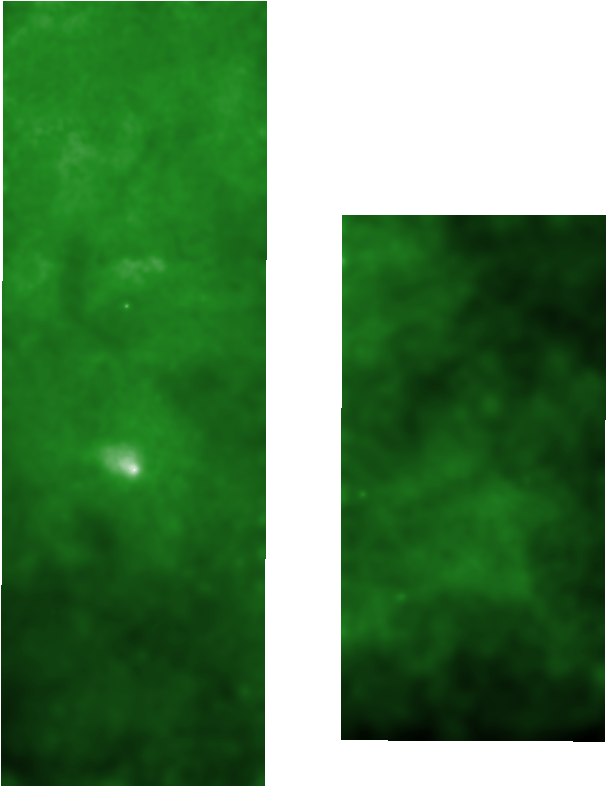

In [47]:
!ds9 $obi/medium_flux.asm -scale log -view colorbar no -cmap load my_grn.lut -export png ds9_03_grn.png -quit

img = display.Image(filename="ds9_03_grn.png")
display.display_png(img)

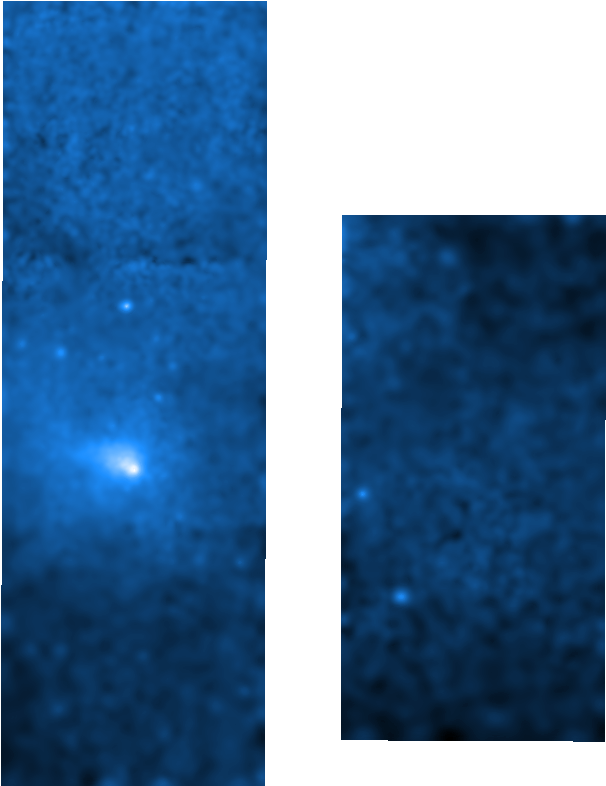

In [48]:
!ds9 $obi/hard_flux.asm -scale log -view colorbar no -cmap load my_blu.lut -export png ds9_03_blu.png -quit

img = display.Image(filename="ds9_03_blu.png")
display.display_png(img)

> Excellent.  

Now let's make a color version of the histogram plot from above to see where we are

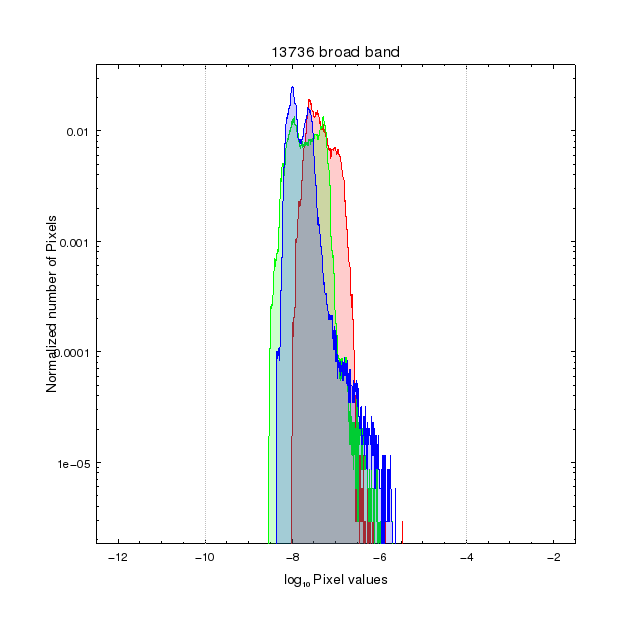

In [49]:
clear()
for band in ["soft","medium","hard"]:
    dmimgcalc.infile=obi+"/{}_flux.asm".format(band)
    dmimgcalc.outfile=obi+"/{}_flux.log".format(band)
    dmimgcalc(clobber=True)
    dmhedit(dmimgcalc.outfile, file=None,op="add",key="BSCALE",value=iscale)
    dmhedit(dmimgcalc.outfile, file=None,op="add",key="BZERO",value=logmin)
    dmimghist.infile=obi+"/{}_flux.log".format(band)
    dmimghist.outfile=obi+"/{}_flux.hist".format(band)
    dmimghist(clobber=True,strict=False)
    hist = read_file(dmimghist.outfile)
    xl = hist.get_column("bin_low").values
    xh = hist.get_column("bin_high").values
    y = hist.get_column("normalized_counts").values
    add_histogram(xl,xh,y)

    
set_histogram("hist1","*.color=red fill.opacity=0.2 fill.style=solid")
set_histogram("hist2","*.color=green fill.opacity=0.2 fill.style=solid")
set_histogram("hist3","*.color=blue fill.opacity=0.2 fill.style=solid")
    
log_scale(Y_AXIS)
add_vline(logmin)
add_vline(logmax)
set_line("all","style=dot color=gray")

set_plot_xlabel("log_{10} Pixel values")
set_plot_ylabel("Normalized number of Pixels")
set_plot_title(obi+" broad band")

my_print("chips_02.png")

In [50]:
clear()

> Ok.  We are still well within the limits we chose. 

Now we create the 3-color JPEG


Setup the input files

In [51]:
dmimg2jpg.infile=obi+"/soft_flux.log"
dmimg2jpg.greenfile=obi+"/medium_flux.log"
dmimg2jpg.bluefile=obi+"/hard_flux.log"

Setup the min and max limits.  We now set all the min to the same and all the max to the same.

In [52]:
dmimg2jpg.minred=logmin
dmimg2jpg.mingreen=logmin
dmimg2jpg.minblue=logmin
dmimg2jpg.maxred=logmax
dmimg2jpg.maxgreen=logmax
dmimg2jpg.maxblue=logmax

Setup the output file name and run it.

In [53]:
dmimg2jpg.outfile="tricolor.jpg"
dmimg2jpg(clobber=True)

and display it

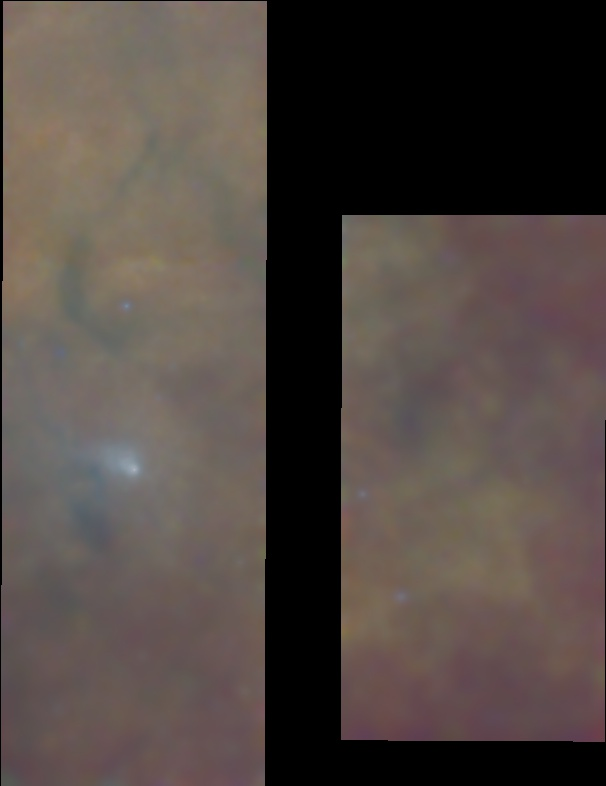

In [54]:
img = display.Image(filename=dmimg2jpg.outfile)
display.display_jpeg(img)

Just for comparison, what does this look like compared to the JPEG created in SDP?

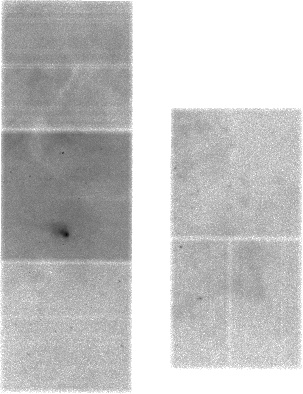

In [55]:
download_chandra_obsids([obi], ["full_img"])
full_field=glob.glob(obi+"/primary/*full_img2.jpg")
img = display.Image(full_field[0])
display.display_jpeg(img)

> Which is better?  You decide.